![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

# TFM - Modelo Baseline de Regresión Lineal



# **_1. Librerías y configuración_**

In [31]:
# Principales

import pandas as pd
import numpy as np
# visuzalizaciones
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots

import plotly.graph_objs as go
from plotly.offline import iplot
import plotly.figure_factory as ff

from sklearn import metrics
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import learning_curve


import gc

In [32]:
# Forzar la recolección de basura
gc.collect()

123097

In [33]:
pd.set_option('display.max_info_columns',110 )
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows',80)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_colwidth', None)
# Ajustar la configuración para mostrar más filas
# pd.set_option('display.max_rows', 500)

# Inicializar la lista to replace
to_replace=['Null','Nan','nan','NULL',None]

# **_2. Funciones_**

In [34]:
#Funcion que agrupa las columnas por tipo de dato

def columnas_por_tipo(df):
    # Filtrar columnas por tipo de datos
    int_columns = [col for col in df.columns if df[col].dtype.name.startswith('int')]
    float_columns = [col for col in df.columns if df[col].dtype.name.startswith('float')]
    boolean_columns=[col for col in df.columns if set(df[col].unique()) <= {0, 1}]
    numeric_cols=int_columns + float_columns
    object_columns = df.select_dtypes(include='object').columns.tolist()
    category_columns = df.select_dtypes(include='category').columns.tolist()

    cat_columns=list(set(category_columns) - set(boolean_columns) )
    # Obtener todas las columnas
    all_columns = set(df.columns)
    # # Columnas de otros tipos
    other_columns = list(all_columns - set(int_columns) - set(float_columns) - set(object_columns) - set(category_columns))

    # Cuento el número de columnas de cada tipo
    num_int_columns = len(int_columns)
    num_float_columns = len(float_columns)
    num_object_columns = len(object_columns)
    num_category_columns = len(category_columns)
    num_other_columns = len(other_columns)

    # Mostrar los resultados
    print("Número de columnas de tipo entero:", num_int_columns)
    print("Columnas de tipo entero:", int_columns)
    print("Número de columnas de tipo float:", num_float_columns)
    print("Columnas de tipo float:", float_columns)
    print("Número de columnas de tipo object:", num_object_columns)
    print("Columnas de tipo object:", object_columns)
    print("Número de columnas de tipo category:", num_category_columns)
    print("Columnas de tipo category:", category_columns)
    print("Número de columnas de otros tipos:", num_other_columns)
    print("Columnas de otros tipos:", other_columns)
    return boolean_columns,numeric_cols,cat_columns,object_columns,other_columns

In [35]:

def reduce_mem_usage(df, turn_cat=False, silence=True):
    """Itera sobre todo el dataset convirtiendo cada columna en el tipo más adecuado para ahorrar memoria.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe que se quiere reducir.
    turn_cat : bool, optional
        Transformación de las columnas objeto o string a category, by default False.

    Returns
    -------
    pd.DataFrame
        Dataframe optimizado.
    """

    start_mem = df.memory_usage().sum() / 1024**2  # Memoria inicial

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object and not isinstance(col_type, pd.CategoricalDtype):
            c_min = df[col].min()
            c_max = df[col].max()

            if pd.api.types.is_numeric_dtype(df[col]):
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)

                # Conversión de float a int si no hay decimales y no hay NaN
                df[col] = df[col].fillna(0)  # Rellenar NaN antes de verificar si son enteros
                if all(df[col].apply(float.is_integer)):
                    df[col] = df[col].astype(np.int64)

        # Conversión de objetos a categoría si turn_cat es True
        if turn_cat and col_type == object:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2  # Memoria final

    if not silence:
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df


# **_3. Carga de datos_**

In [36]:
df= pd.read_csv('./data/dfbaseline_sin_process.csv',index_col=False,low_memory=False)


# **_4. Exploración_**

In [37]:
df.shape

(10032, 109)

Eliminamos si existieran las columnas duplicadas

In [38]:
df = df.loc[:, ~df.columns.duplicated()]


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10032 entries, 0 to 10031
Data columns (total 109 columns):
 #    Column                                            Non-Null Count  Dtype  
---   ------                                            --------------  -----  
 0    Unnamed: 0                                        10032 non-null  int64  
 1    url                                               10032 non-null  object 
 2    m2_constr                                         10032 non-null  float64
 3    distrito                                          10032 non-null  object 
 4    cod_distrito                                      10032 non-null  int64  
 5    barrio                                            10032 non-null  object 
 6    cod_barrio                                        10032 non-null  int64  
 7    letra_ce                                          2150 non-null   object 
 8    tipologia                                         10032 non-null  object 
 9    esta

La columna precio es de tipo int64, la transformamos a float64, ya que el precio de venta de las viviendas es la variable objetivo en nuestro análisis y el tipo de dato float64 es adecuado para manejar valores de precio con precisión decimal.

In [40]:

df["precio"] = df["precio"].astype("float64")


## **_4.1. Eliminación columnas con 80% nulos_**

Identificamos las columnas con mas de un 80% de los valores nulos y los eliminamos

In [41]:
# Identificamos las columnas con más del 85% de valores nulos
for col in df.columns:
    porcentaje_nulos = df[col].isnull().mean() * 100
    if porcentaje_nulos > 80:
        print(f'Columna {col}: {porcentaje_nulos:.2f}% nulos')

Columna amueblado: 87.83% nulos
Columna balcon: 85.89% nulos
Columna garaje: 80.37% nulos
Columna num_plantas: 97.85% nulos
Columna inmueble_ingresos: 99.90% nulos
Columna alquiler_opcion_a_compra: 99.97% nulos
Columna nuda_propiedad: 99.88% nulos
Columna tipo_inmueble: 81.13% nulos
Columna tiene_armario: 81.22% nulos
Columna acceso_discapacidad: 97.53% nulos
Columna armarios: 87.65% nulos
Columna tipo_suelo: 86.72% nulos
Columna gastos_comunidad: 94.62% nulos
Columna tipo_fachada: 98.20% nulos
Columna agua_caliente: 93.13% nulos
Columna portero: 97.70% nulos
Columna estaciones_metroligero: 81.17% nulos


In [42]:
# Definir el umbral de nulos (85%)
umbral_nulos = 0.80
# Calcular el porcentaje de nulos por columna
porcentaje_nulos = df.isnull().mean()
# Filtrar y eliminar columnas con más del 85% de nulos
df = df.loc[:, porcentaje_nulos <= umbral_nulos]



In [43]:
df.precio.describe()

count      10032.00
mean      889205.03
std      1159695.89
min        25000.00
25%       239500.00
50%       480000.00
75%      1090000.00
max     19950000.00
Name: precio, dtype: float64

## **_4.2. Agrupación viviendas por precio promedio barrio_**

Generamos una variable  mediante la agrupación de códigos de barrio, calculando el precio promedio por barrio,clasificando codigo de barrio en cinco grupos distintos en función de sus precios promedio relativos.
Realizamos esto por que consideramos que las viviendas ubicadas en el mismo barrio tienden a tener precios similares.

In [44]:
# Calcular el precio promedio por barrio
codbarrio_precios = df.groupby('cod_barrio')['precio'].mean().reset_index()

# Clasificar los códigos de barrio en cinco grupos y obtener los límites de los intervalos
codbarrio_precios['cod_barrio_group'], bins = pd.qcut(
    codbarrio_precios['precio'], q=5, labels=[1, 2, 3, 4, 5], retbins=True
)

# Crear un diccionario de mapeo para asignar grupos a cada barrio en el DataFrame original
cod_barrio_mapping = dict(zip(codbarrio_precios['cod_barrio'], codbarrio_precios['cod_barrio_group']))
df['cod_barrio_group'] = df['cod_barrio'].map(cod_barrio_mapping)

# Contar viviendas por grupo
cod_barrio_group_counts = df["cod_barrio_group"].value_counts(dropna=False).sort_index()

# Descripciones de los grupos con rangos de precios
descriptions = {
    1: "las más baratas entre todas las categorías",
    2: "con precios moderadamente bajos en relación con los demás grupos",
    3: "con un rango de precios similar a las del Grupo 4",
    4: "más costosas que las del Grupo 2, pero aún no están entre las más caras",
    5: "las viviendas más caras en el conjunto de datos"
}

# Mostrar la descripción de cada grupo con su rango de precios
for i, (group, count) in enumerate(cod_barrio_group_counts.items()):
    lower_bound = bins[i]  # Límite inferior del grupo
    upper_bound = bins[i + 1]  # Límite superior del grupo
    print(
        f"Grupo {group}: Este grupo contiene {count} viviendas. "
        f"Rango de precios: {lower_bound:.2f} - {upper_bound:.2f}. "
        f"Estas viviendas son {descriptions.get(group, 'una descripción no especificada.')}"
    )


Grupo 1: Este grupo contiene 1618 viviendas. Rango de precios: 111940.91 - 232408.65. Estas viviendas son las más baratas entre todas las categorías
Grupo 2: Este grupo contiene 1213 viviendas. Rango de precios: 232408.65 - 334194.44. Estas viviendas son con precios moderadamente bajos en relación con los demás grupos
Grupo 3: Este grupo contiene 1333 viviendas. Rango de precios: 334194.44 - 590108.70. Estas viviendas son con un rango de precios similar a las del Grupo 4
Grupo 4: Este grupo contiene 2212 viviendas. Rango de precios: 590108.70 - 937714.29. Estas viviendas son más costosas que las del Grupo 2, pero aún no están entre las más caras
Grupo 5: Este grupo contiene 3656 viviendas. Rango de precios: 937714.29 - 3109250.00. Estas viviendas son las viviendas más caras en el conjunto de datos


In [45]:
codbarrio_precios.describe()

,cod_barrio,precio
count,131.00,131.00
mean,110.70,676477.02
std,58.91,619669.96
min,11.00,111940.91
25%,62.50,256213.67
50%,111.00,439243.16
75%,157.50,865059.22
max,215.00,3109250.00


## **_4.3. Correlación_**

Creo un dataset solo con las variables numericas , vemos la correlación entre las mismas y eliminamos una de las variables que tenga con otra
una correlación mayor del 90% para reducir la multicolinealidad y mejorar el rendimiento del modelo

In [46]:
# Seleccionar solo las columnas numéricas
df_numerico = df.select_dtypes(include=["number"])

# Calcular la matriz de correlación
correlation_matrix = df_numerico.corr()
# Calcular la matriz de correlación
#correlation_matrix = df.corr()

# Seleccionar las correlaciones superiores al 90% (excluyendo la diagonal)
correlated_pairs = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.90:  # Umbral del 90%
            col1 = correlation_matrix.columns[i]
            col2 = correlation_matrix.columns[j]
            correlated_pairs.add((col1, col2))

# Elegir una columna de cada par para eliminar (por simplicidad, la segunda de cada par)
columns_to_drop = {pair[1] for pair in correlated_pairs}

# Eliminar las columnas correlacionadas
df_numerico = df_numerico.drop(columns=columns_to_drop)

# Mostrar las columnas eliminadas
print("Columnas eliminadas por alta correlación:", columns_to_drop)


Columnas eliminadas por alta correlación: {'servicios_profesionales', 'hog_con_5', 'cultura_entretenimiento', 'hosteleria_restauracion', 'num_personas_mujeres', 'viv_usadas_transacciones', 'hog_con_4', 'cod_barrio', 'hog_con_9', 'tamaño_del_hogar_(nº_de_personas_en_la_vivienda)', 'hog_con_11', 'hog_con_10', 'hog_con_2', 'hog_con_15_y_más', 'hog_con_12', 'mediana_de_la_renta_por_unidad_de_consumo', 'renta_bruta_media_por_persona', 'hog_con_8', 'hogares', 'renta_bruta_media_por_hogar', 'renta_neta_media_por_hogar', 'renta_neta_media_por_persona', 'hog_con_1', 'hog_con_7', 'm2_utiles', 'hog_con_3', 'comercio_serviciosminoristas', 'num_lineas_buses'}


Representación grafica de la matriz de correlación entre las varibles que quedan en el dataset

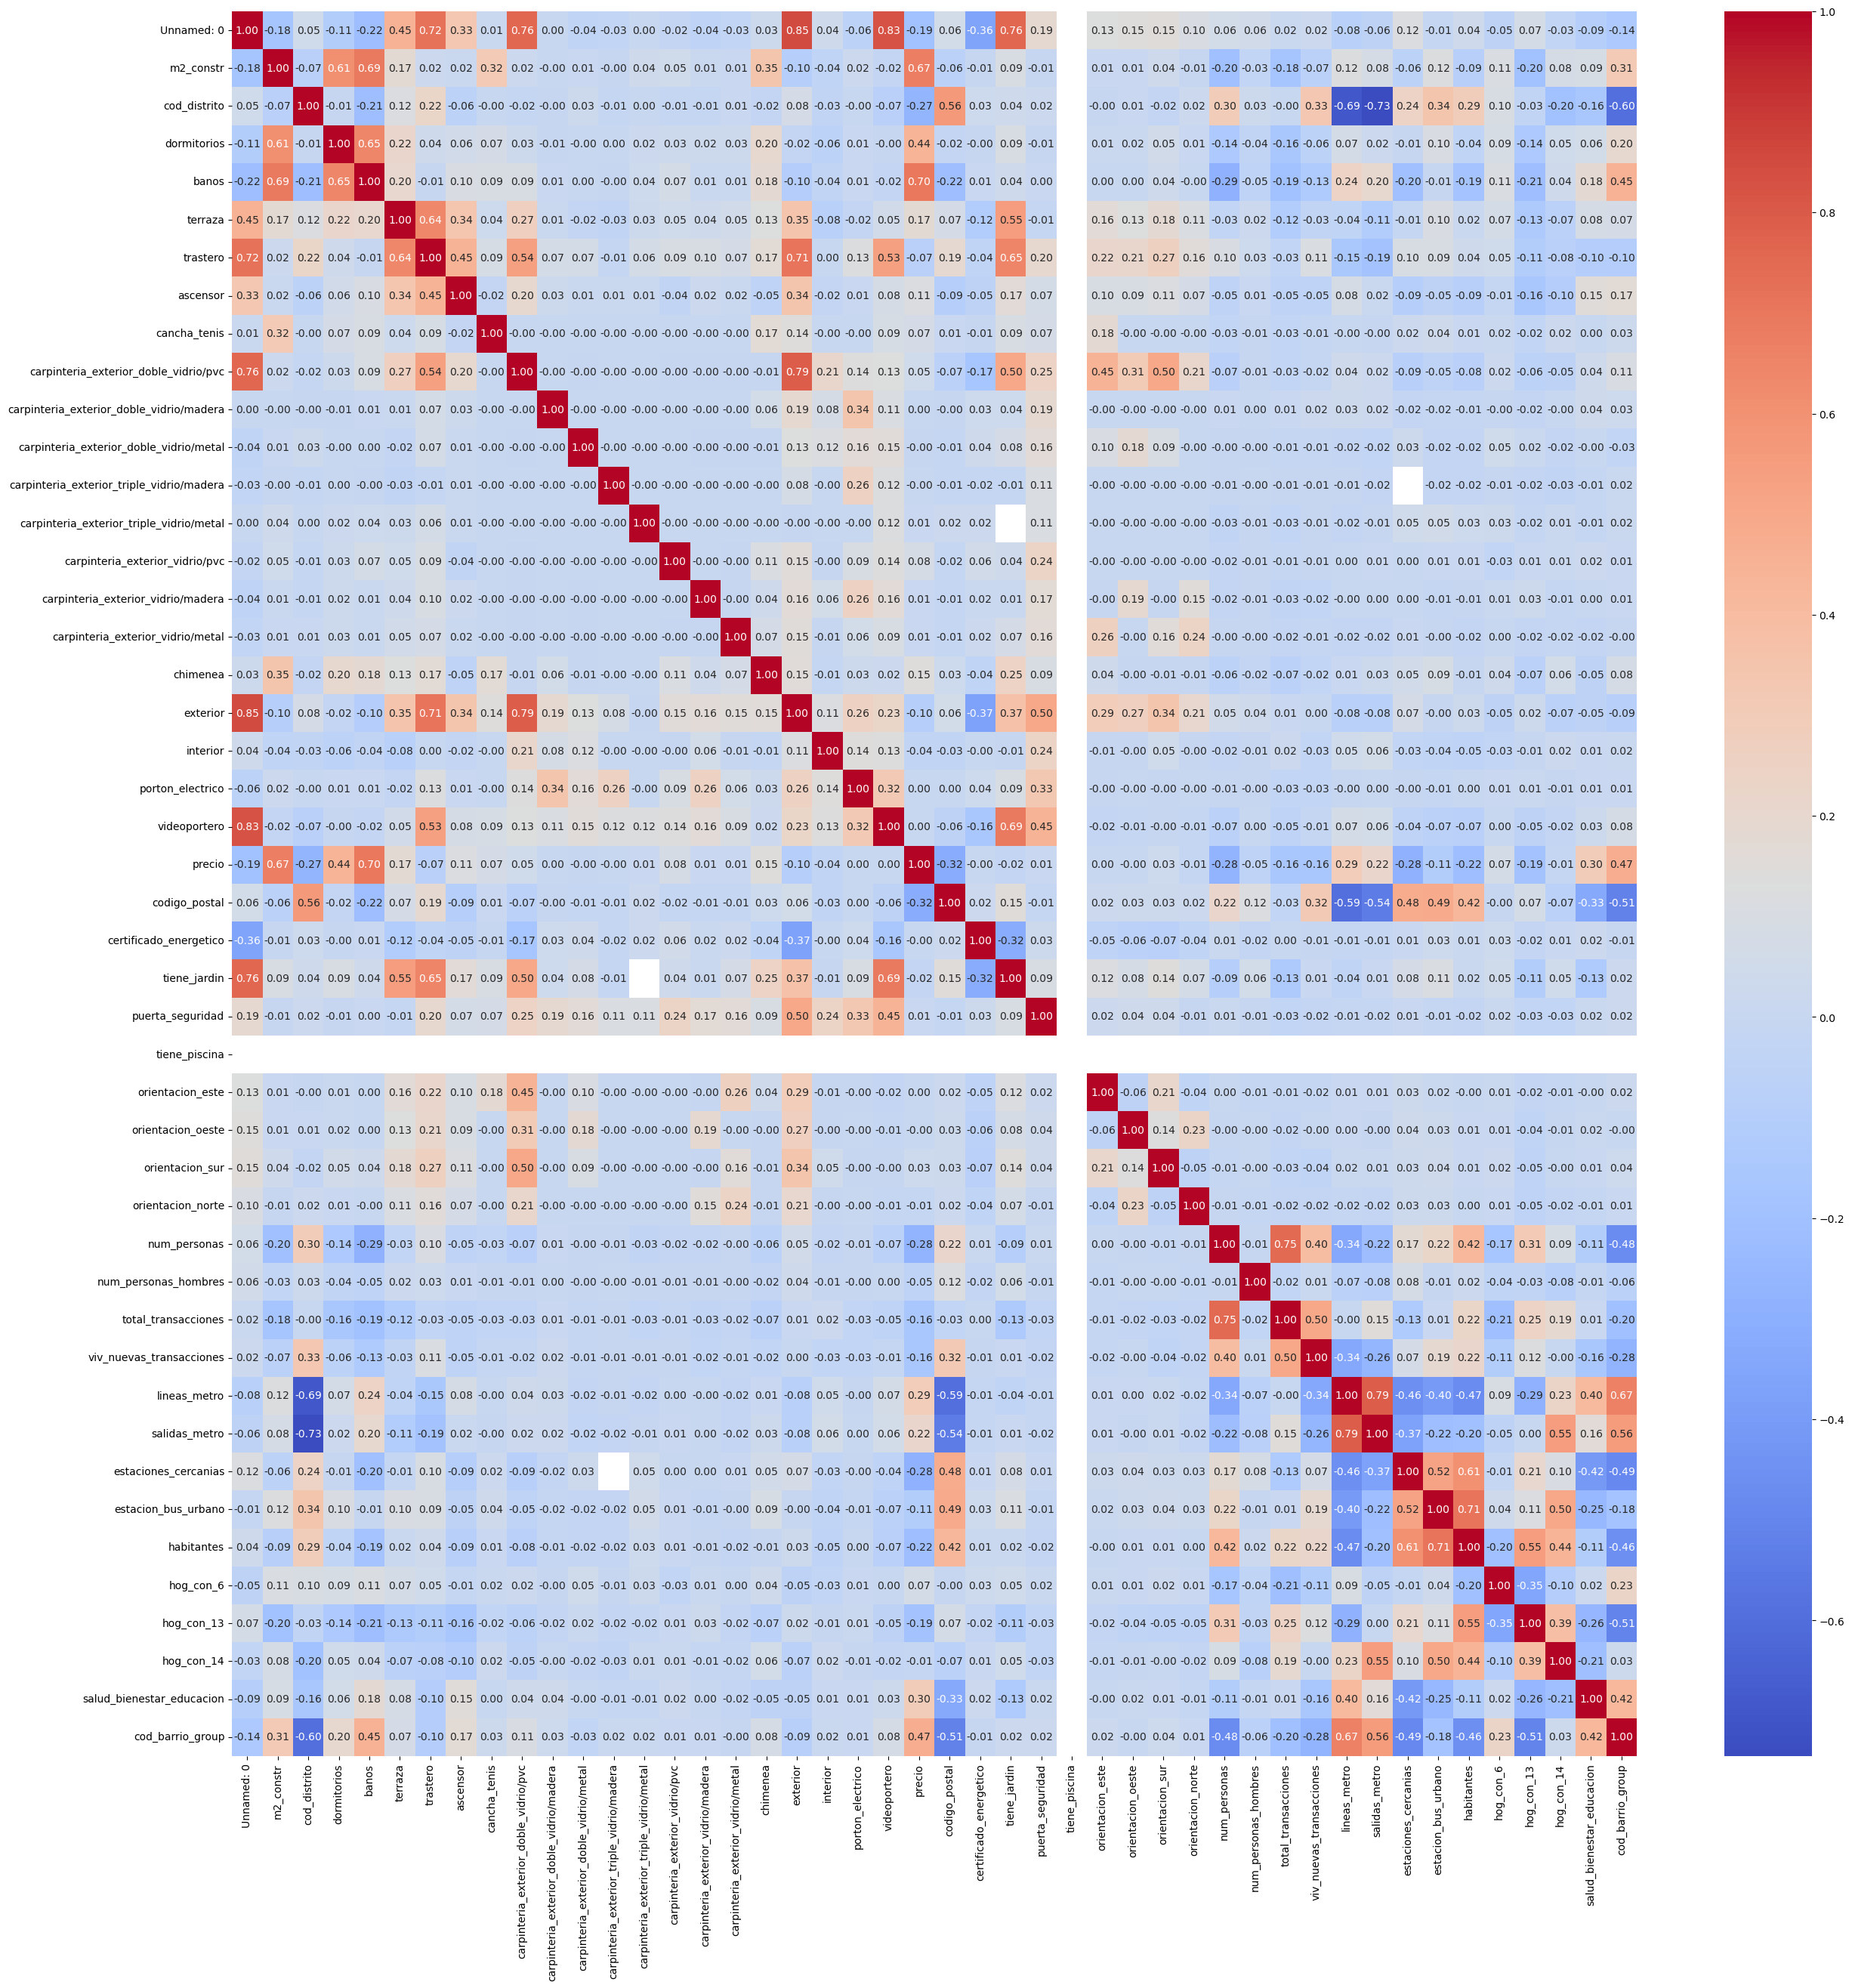

In [47]:

# Calcular la matriz de correlación
correlation_matrix = df_numerico.corr()

# Graficar el heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f",cmap='coolwarm')
plt.show()


In [48]:

# Selecciona solo las columnas numéricas
df_numerico = df_numerico.select_dtypes(include=['number'])

# Calcula la matriz de correlación
corr = df_numerico.corr()

# Selecciona la fila correspondiente a 'precio'
corr_precio = corr.loc['precio']

print(corr_precio)


Unnamed: 0                                  -0.19
m2_constr                                    0.67
cod_distrito                                -0.27
dormitorios                                  0.44
banos                                        0.70
terraza                                      0.17
trastero                                    -0.07
ascensor                                     0.11
cancha_tenis                                 0.07
carpinteria_exterior_doble_vidrio/pvc        0.05
carpinteria_exterior_doble_vidrio/madera     0.00
carpinteria_exterior_doble_vidrio/metal     -0.00
carpinteria_exterior_triple_vidrio/madera   -0.00
carpinteria_exterior_triple_vidrio/metal     0.01
carpinteria_exterior_vidrio/pvc              0.08
carpinteria_exterior_vidrio/madera           0.01
carpinteria_exterior_vidrio/metal            0.01
chimenea                                     0.15
exterior                                    -0.10
interior                                    -0.04


# 5. Separación entre train y test

En este modelo baseline voy a tomar solo las variables numericas del dataset

In [49]:
print(f"El DataFrame df_numericotiene {df_numerico.shape[0]} filas y {df_numerico.shape[1]} columnas.")

El DataFrame df_numericotiene 10032 filas y 46 columnas.


In [50]:
# Guardamos la  variable target en una variable "target"
target = 'precio'
df_numerico[target].head()

0   2000000.00
1    287000.00
2    650000.00
3    650000.00
4    599999.00
Name: precio, dtype: float64

In [51]:
#Incluyo la columna url para crear df_ids para almacenar los identificadores de lcada vivienda
dfbaseline=df_numerico
dfbaseline["url"] = df["url"]
print(dfbaseline['cod_barrio_group'].value_counts())


cod_barrio_group
5    3656
4    2212
1    1618
3    1333
2    1213
Name: count, dtype: int64


In [52]:


# Dividir las columnas objetivo y características
#y = dfbaseline['cod_barrio_group'].values  # Asegúrate de usar la columna correcta para 'cod_barrio_group'
y = dfbaseline['precio'].values  # Asegúrate de usar la columna correcta para 'cod_barrio_group'
#X = dfbaseline.drop(columns=['cod_barrio_group', 'url'])
df_ids = dfbaseline[['url']]
X = dfbaseline.drop(columns=['url','precio'])

# Primera clasificación entre train y test, estratificando por 'cod_barrio_group'
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, df_ids, test_size=0.2, random_state=42, stratify=X['cod_barrio_group'], shuffle=True
)

# Verificar la distribución de las clases en train y test
print("Distribución en el conjunto de entrenamiento:")
#print(y_train.value_counts())

print(pd.Series(y_train).value_counts())
print("Distribución en el conjunto de test:")
#print(y_test.value_counts())
print(pd.Series(y_test).value_counts())

# Segunda división: Train y Validación a partir de X_train, estratificando también
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=X_train['cod_barrio_group'], shuffle=True
)

# Verificar la distribución de las clases en train y validación
print("Distribución en el conjunto de validación:")

print(pd.Series(y_val).value_counts())
# Número de registros del dataset de train, test y validación
print("Número de observaciones")
print("- Train: ", X_train.shape[0])
print("- Test:  ", X_test.shape[0])
print("- Val:   ", X_val.shape[0])

# Resetear los índices para cada conjunto
dftrain = X_train.reset_index(drop=True)
dftest = X_test.reset_index(drop=True)
dfval = X_val.reset_index(drop=True)


Distribución en el conjunto de entrenamiento:
220000.00     53
350000.00     50
240000.00     49
230000.00     49
260000.00     48
              ..
407000.00      1
155800.00      1
374100.00      1
849999.00      1
2710000.00     1
Name: count, Length: 1437, dtype: int64
Distribución en el conjunto de test:
550000.00     18
650000.00     16
320000.00     16
950000.00     14
330000.00     13
              ..
107000.00      1
4550000.00     1
227000.00      1
920000.00      1
89000.00       1
Name: count, Length: 735, dtype: int64
Distribución en el conjunto de validación:
230000.00     15
225000.00     13
210000.00     12
240000.00     12
165000.00     11
              ..
865000.00      1
4750000.00     1
99900.00       1
222500.00      1
214900.00      1
Name: count, Length: 691, dtype: int64
Número de observaciones
- Train:  6420
- Test:   2007
- Val:    1605


## **_5.1. Imputación de nulos_**

In [53]:
# Crear un diccionario para almacenar las medias por grupo (por cada columna)
medias_por_grupo = {}

# Calcular la media de cada columna en X_train agrupada por 'cod_barrio_group'
for columna in X_train.columns:
    if X_train[columna].isnull().sum() > 0:  # Solo calculamos si la columna tiene nulos
        # Agrupar por 'cod_barrio_group' y calcular la media de cada grupo
        medias_por_grupo[columna] = X_train.groupby('cod_barrio_group')[columna].mean().to_dict()

# Imputar valores nulos en X_train según las medias por grupo
X_train_imputado = X_train.copy()
for columna, medias in medias_por_grupo.items():
    # Imputar solo las filas que tienen nulos
    for grupo, media in medias.items():
        # Filtrar las filas por grupo y reemplazar los valores nulos con la media correspondiente
        X_train_imputado.loc[(X_train_imputado['cod_barrio_group'] == grupo) & (X_train_imputado[columna].isnull()), columna] = media

# Imputación en X_val y X_test (usando las mismas medias por grupo que en X_train)
X_val_imputado = X_val.copy()
X_test_imputado = X_test.copy()

for columna, medias in medias_por_grupo.items():
    for grupo, media in medias.items():
        # Imputar valores nulos en X_val y X_test
        X_val_imputado.loc[(X_val_imputado['cod_barrio_group'] == grupo) & (X_val_imputado[columna].isnull()), columna] = media
        X_test_imputado.loc[(X_test_imputado['cod_barrio_group'] == grupo) & (X_test_imputado[columna].isnull()), columna] = media

# Mostrar el DataFrame imputado para verificar
print(X_train_imputado.head())
print(X_val_imputado.head())
print(X_test_imputado.head())


      Unnamed: 0  m2_constr  cod_distrito  dormitorios  banos  terraza  \
5144        5144      50.00            15         2.00   1.00     0.84   
7866        7866      92.00             2         2.00   2.00     0.74   
2284        2284      92.00             3         3.00   1.00     0.00   
3626        3626      26.00             2         1.00   1.00     0.74   
3739        3739      80.00            10         2.59   1.00     0.84   

      trastero  ascensor  cancha_tenis  carpinteria_exterior_doble_vidrio/pvc  \
5144      0.59      0.87          0.00                                   0.08   
7866      1.00      1.00          0.00                                   0.09   
2284      0.00      1.00          0.00                                   0.00   
3626      0.63      0.91          0.00                                   0.09   
3739      1.00      1.00          0.00                                   0.08   

      carpinteria_exterior_doble_vidrio/madera  \
5144              


## **_5.2 Entrenamiento_**

In [54]:
X_train=X_train_imputado
X_val=X_val_imputado
X_test=X_test_imputado
X_train = X_train.drop(columns=['cod_barrio_group'])
X_test = X_test.drop(columns=['cod_barrio_group'])
X_val = X_val.drop(columns=['cod_barrio_group'])
# Import library for Linear Regression
#from sklearn.linear_model import LinearRegression

# Create a Linear regressor
lm = LinearRegression()

# 2. Inicializar RFE con el modelo y seleccionar las mejores 5 características
selector = RFE(lm, n_features_to_select=10)

# 3. Ajustar el selector a los datos de entrenamiento (esto realiza la selección)
selector = selector.fit(X_train, y_train)

# 4. Obtener las columnas seleccionadas
selected_columns = X_train.columns[selector.support_]

# 5. Imprimir las variables más importantes
print("Variables más importantes:", selected_columns)


# Train the model using the training sets
lm.fit(X_train, y_train)
# Converting the coefficient values to a dataframe
coeffcients = pd.DataFrame([X_train.columns, lm.coef_]).T
coeffcients = coeffcients.rename(columns={0: 'Attribute', 1: 'Coefficients'})
coeffcients

Variables más importantes: Index(['banos', 'terraza', 'trastero', 'ascensor', 'cancha_tenis',
       'carpinteria_exterior_vidrio/pvc', 'carpinteria_exterior_vidrio/metal',
       'chimenea', 'porton_electrico', 'tiene_jardin'],
      dtype='object')


,Attribute,Coefficients
0,Unnamed: 0,-13.22
1,m2_constr,3339.58
2,cod_distrito,-14686.26
3,dormitorios,-63864.42
4,banos,302264.47
5,terraza,189150.65
6,trastero,-33594.22
7,ascensor,162796.31
8,cancha_tenis,-5819254.22
9,carpinteria_exterior_doble_vidrio/pvc,40827.19


## **_5.3 Evaluación sobre train_**

In [55]:
### 3.2 Evaluación sobre train

In [56]:
# Model prediction on train df
y_pred = lm.predict(X_train)
# Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

R^2: 0.6303125157442173
MAE: 345802.64774184255
MSE: 475383284017.58484
RMSE: 689480.4449856319


## **_5.4 Evaluación sobre validación_**

In [57]:
# Model prediction on val df
y_pred_val = lm.predict(X_val)
# Model Evaluation
print('R^2:',metrics.r2_score(y_val, y_pred_val))
print('MAE:',metrics.mean_absolute_error(y_val, y_pred_val))
print('MSE:',metrics.mean_squared_error(y_val, y_pred_val))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_val, y_pred_val)))

R^2: 0.6493432558117227
MAE: 362263.13015499635
MSE: 507921648999.9521
RMSE: 712686.220576736


## **_5.5 Evaluación sobre test_**

In [58]:
# Predicting Test df with the model
y_test_pred = lm.predict(X_test)
# Model Evaluation
acc_linreg = metrics.r2_score(y_test, y_test_pred)
print('R^2:', acc_linreg)
print('MAE:',metrics.mean_absolute_error(y_test, y_test_pred))
print('MSE:',metrics.mean_squared_error(y_test, y_test_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

R^2: 0.6335828980675624
MAE: 351446.9270365568
MSE: 530511688799.72144
RMSE: 728362.333457546


- **𝑅^2**: Es una medida de la relación lineal entre X e Y. Se interpreta como la proporción de la varianza en la variable dependiente que es predecible a partir de la variable independiente.

- **MAE**: Es la media del valor absoluto de los errores. Mide la diferencia entre dos variables continuas, en este caso, los valores reales y los valores predichos de y.

- **MSE**: El error cuadrático medio (MSE, por sus siglas en inglés) es similar al MAE, pero eleva al cuadrado la diferencia antes de sumarlas todas, en lugar de usar el valor absoluto.

- **RMSE**: La raíz cuadrada del error cuadrático medio (RMSE, por sus siglas en inglés) es la raíz cuadrada del MSE.

## **_5.6 Interpretación grafica del modelo_**

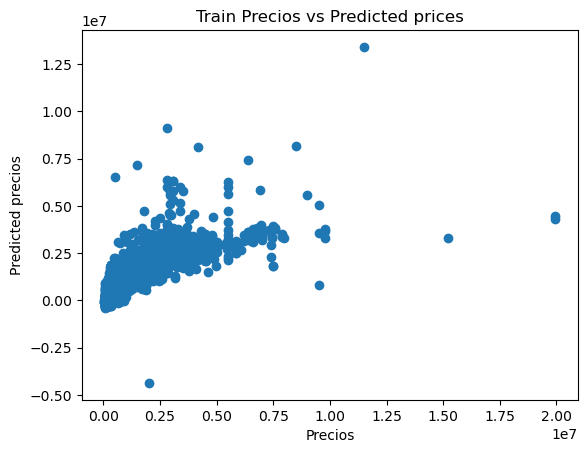

In [65]:
# Visualizing the differences between actual prices and predicted values
plt.scatter(y_train, y_pred)
plt.xlabel("Precios")
plt.ylabel("Predicted precios")
plt.title("Train Precios vs Predicted prices")
plt.show()

El gráfico representa una relación entre los precios reales y los precios predichos
1. **Ejes del gráfico**:
   - El eje horizontal (x) muestra los **precios reales** de las viviendas, etiquetados como "Precios".
   - El eje vertical (y) muestra los **precios predichos** por el modelo, etiquetados como "Predicted precios".

2. **Distribución de los puntos**:
   - Cada punto en el gráfico representa una observación individual (una vivienda).
   - Si el modelo fuera perfecto, todos los puntos estarían alineados sobre la línea diagonal que va de la esquina inferior izquierda (1,1) a la superior derecha (5,5). Esto indicaría que las predicciones coinciden exactamente con los valores reales.
   - Sin embargo, en este caso, se observa una **dispersión considerable** alrededor de la diagonal. Esto indica que las predicciones del modelo tienen cierto grado de error.

3. **Implicaciones del gráfico**:
   - El nivel de dispersión muestra como de bueno es el modelo calculando las prediciones de los precios. Una dispersión alta indica que hay diferencias  entre los precios reales y los predichos, por lo que el modelo necesita ajustes.
   - Algunas observaciones están muy alejadas de la diagonal, reflejando **predicciones especialmente incorrectas** (sobreestimación o subestimación).


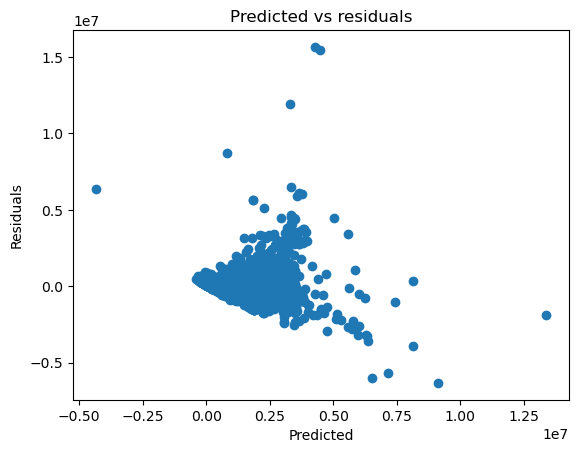

In [ ]:
# Checking residuals
plt.scatter(y_pred,y_train-y_pred)
plt.title("Predicted vs residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuales")
plt.show()

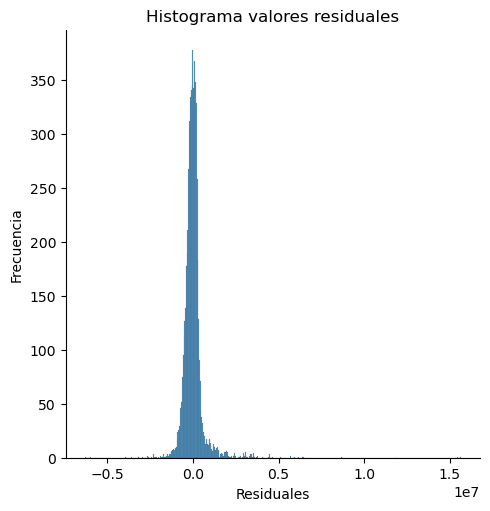

In [66]:
# Checking Normality of errors
sns.displot(y_train-y_pred)
plt.title("Histograma valores residuales")
plt.xlabel("Residuales")
plt.ylabel("Frecuencia")
plt.show()

El gráfico presenta una forma acampanada centrada en torno al valor cero, lo cual sugiere que los errores son simétricos y que no hay un sesgo claro en las predicciones del modelo.El modelo de regresión cumple con la suposición de normalidad de los errores, lo que permite asegurar la calidad y validez del modelo.

In [67]:
#Mostramos algunos de los valores outliers en la predición del conjunto de train

# Calcular errores (diferencias absolutas entre y_train y y_pred)
errores = pd.Series(np.abs(y_train - y_pred), index=X_train.index)

# Establecer el umbral para identificar outliers (e.g., 2 desviaciones estándar)
umbral = errores.mean() + 2 * errores.std()

# Identificar índices de los outliers
outliers_indices = errores[errores > umbral].index

# Extraer IDs de las observaciones consideradas como outliers
outliers_ids = ids_train.loc[outliers_indices]

# Mostrar los IDs de los outliers
print("IDs de los outliers:")
print(outliers_ids)

# (Opcional) Extraer también las características de los outliers
outliers_X = X_train.loc[outliers_indices]
print("Características de los outliers:")
print(outliers_X)


IDs de los outliers:
                                                                                   url
2369                                         https://www.indomio.es/anuncios/96776041/
267                                          https://www.indomio.es/anuncios/94463387/
5978  https://www.pisos.com/comprar/piso-salamanca_castellana28006-40067391253_149200/
2843                                         https://www.indomio.es/anuncios/96877641/
4806  https://www.pisos.com/comprar/piso-salamanca_castellana28006-47546261838_100500/
...                                                                                ...
2840                                         https://www.indomio.es/anuncios/96875883/
1253                                         https://www.indomio.es/anuncios/96414139/
5338  https://www.pisos.com/comprar/piso-salamanca_castellana28006-45923397092_524612/
4027             https://www.pisos.com/comprar/piso-recoletos28001-42548102224_149200/
7170  https://www.piso

In [68]:
#Hacemos el mismo estudio de los outliers en el conjunto de validación
# Calcular errores (diferencias absolutas entre y_train y y_pred)
errores = pd.Series(np.abs(y_val - y_pred_val), index=X_val.index)

# Establecer el umbral para identificar outliers (e.g., 2 desviaciones estándar)
umbral = errores.mean() + 2 * errores.std()

# Identificar índices de los outliers
outliers_indices = errores[errores > umbral].index

# Extraer IDs de las observaciones consideradas como outliers
outliers_ids = ids_train.loc[outliers_indices]

# Mostrar los IDs de los outliers
print("IDs de los outliers:")
print(outliers_ids)

# (Opcional) Extraer también las características de los outliers
outliers_X = X_val.loc[outliers_indices]
print("Características de los outliers:")
print(outliers_X)

IDs de los outliers:
                                                                                                                     url
1445                                                                           https://www.indomio.es/anuncios/96517359/
7074                                         https://www.pisos.com/comprar/piso-justicia_chueca28001-42515655177_102100/
2899                                                                           https://www.indomio.es/anuncios/96892251/
6045                                        https://www.pisos.com/comprar/piso-chamberi_almagro28046-41671369528_109300/
1697                                                                           https://www.indomio.es/anuncios/96585755/
9203  https://www.redpiso.es/inmueble/piso-en-venta-en-avenida-menendez-pelayo-ibiza-retiro-madrid-madrid-RP962024130172
4784                                    https://www.pisos.com/comprar/piso-salamanca_castellana28006-45872826974_100500/
1921       

Por ultimo mostramos la curva de aprendizaje del modelo

## **_5.6 Curva de aprendizaje_**

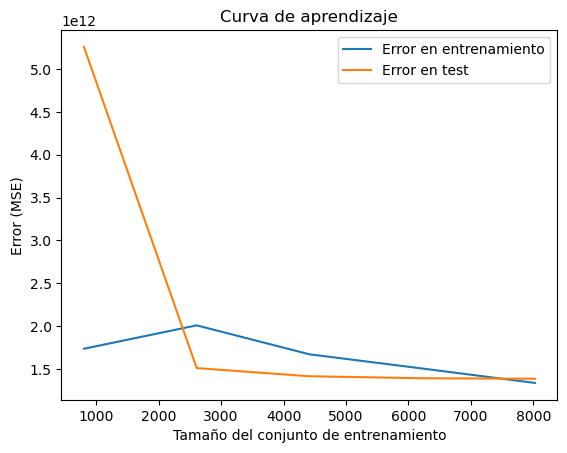

In [69]:

# Concatenamos los conjuntos de datos sin valores nulos
X = pd.concat([X_train_imputado, X_val_imputado, X_test_imputado])


train_sizes, train_scores, test_scores = learning_curve(lm, X, y, cv=5, scoring='neg_mean_squared_error')
plt.plot(train_sizes, -train_scores.mean(axis=1), label='Error en entrenamiento')
plt.plot(train_sizes, -test_scores.mean(axis=1), label='Error en test')
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Error (MSE)")
plt.legend()
plt.title("Curva de aprendizaje")
plt.show()


La gráfica representa la **Curva de Aprendizaje**, donde el eje X muestra el **Tamaño del conjunto de entrenamiento** y el eje Y el **Error (MSE)**. 
Hay dos líneas: 
1. Una azul para el **error en entrenamiento**.
2. Una naranja para el **error en test**.

1. **Error en entrenamiento (línea azul)**:Comienza relativamente bajo y se mantiene bastante constante ,lo que el modelo tiene un buen ajuste a los datos de entrenamiento desde el principio.

2. **Error en test (línea naranja)**:
   - Comienza muy alto  y decrece drásticamente con el aumento del tamaño del conjunto de entrenamiento.Finalmente se estabiliza , lo que indica que el modelo necesita un conjunto de datos amplio para hacer predicciones razonables.

* Interpretación del Modelo
1. **Sesgo bajo, varianza inicial alta**:
   - El error en el conjunto de entrenamiento es bajo, el modelo es capaz de capturar patrones en los datos de entrenamiento.Aunque inicialmente, el error en test es mucho mayor  disminuye al proporcionar más datos de entrenamiento.

2. **Curva estabilizada**:
   - Tanto el error en entrenamiento como en test convergen alrededor de un valor similar , lo que indica que el modelo no se beneficia significativamente de más datos en este punto, alcanzando una **generalización aceptable**.

3. **Potencial sobreajuste limitado**:
   - La pequeña diferencia entre ambos errores una vez estabilizados sugiere que el modelo está equilibrado y no sufre de **sobreajuste** (overfitting).

* Consideraciones para mejorar
- El error absoluto final sigue siendo alto para el problema, por lo que vamos a realizar los siguientes acciones:
  1. **Revisar las características**: Añadir ls varaibles categoricas y transformar las existentes para mejorar la capacidad del modelo.
  2. **Explorar modelos más complejos**: Probar modelos más robustos que puedan capturar relaciones no lineales en los datos.
  3. **Normalizar o estandarizar las variables**: Esto puede mejorar la estabilidad de los coeficientes y el desempeño.

